# regression analysis of the database
- database.xlsx contains the experimental data and descriptors of chemicals (calculated in the 1st step)

In [1]:
import pandas as pd
from IPython.display import SVG, display
from AnalyzeUtil import selected_columns,get_coeff_list,to_graph,heatmap,ENWrapper,RFRWrapper

In [2]:
#load data
df = pd.read_excel('database.xlsx',sheet_name="default")

#select only "important" parameters
df=df[selected_columns]       
df=df.rename(columns={'s': 'Conductivity',"thickness(um)":"Thickness"})
param_list=df.columns

#calc z-score
for cl in df.columns:
    df[cl]=df[[cl]].apply(lambda x: (x-x.mean()) / (x.std()))
df=df.dropna(how='all').dropna(how='all', axis=1)

df

,salt,A_LUMO,D_HOMO,HOMO_LUMO_gap,Thickness,Conductivity,A_SlogP,A_TPSA,D_SlogP,D_TPSA
0,-1.190238,-0.954825,-1.664473,-1.224557,-1.962277,-0.478924,-0.358048,-0.687184,-2.089717,1.883602
1,0.000000,-0.954825,-1.664473,-1.224557,-0.804212,-0.097284,-0.358048,-0.687184,-2.089717,1.883602
2,1.190238,-0.954825,-1.664473,-1.224557,0.960459,3.235919,-0.358048,-0.687184,-2.089717,1.883602
3,-1.190238,-0.954825,0.454473,1.065621,0.629583,-0.288707,-0.358048,-0.687184,0.595392,-0.642156
4,0.000000,-0.954825,0.454473,1.065621,-0.583628,-0.237972,-0.358048,-0.687184,0.595392,-0.642156
5,1.190238,-0.954825,0.454473,1.065621,0.078123,-0.428665,-0.358048,-0.687184,0.595392,-0.642156
6,-1.190238,-0.954825,0.176579,0.765270,-0.583628,-0.318941,-0.358048,-0.687184,-0.046852,0.685022
7,0.000000,-0.954825,0.176579,0.765270,0.408999,-0.414294,-0.358048,-0.687184,-0.046852,0.685022
8,1.190238,-0.954825,0.176579,0.765270,-0.032168,-0.395324,-0.358048,-0.687184,-0.046852,0.685022
9,-1.190238,1.135805,1.583420,1.028078,1.208616,-0.190577,-0.545415,1.374369,0.831343,-0.642156


# analyze by a normal approach
- normal correlation analysis

In [3]:
#calculate correlation coefficients
coeff_dict=df.corr().to_dict()

#convert correlation data to dependency graph format
normal_coeff_list=[]
for param1,v in coeff_dict.items():
    for param2 in v:
        # for comparison with the next approach, abusolute values  will be recorded
        val=abs(coeff_dict[param1][param2])
        
        #here, diagonal elements were set to be zero
        if val!=1:
            temp=(param1,param2,val)
            normal_coeff_list.append(temp)

# let's check heatmap
- we can see many parameters are correlated to conductivity
    - the number of the parameters may be too much for easier understanding

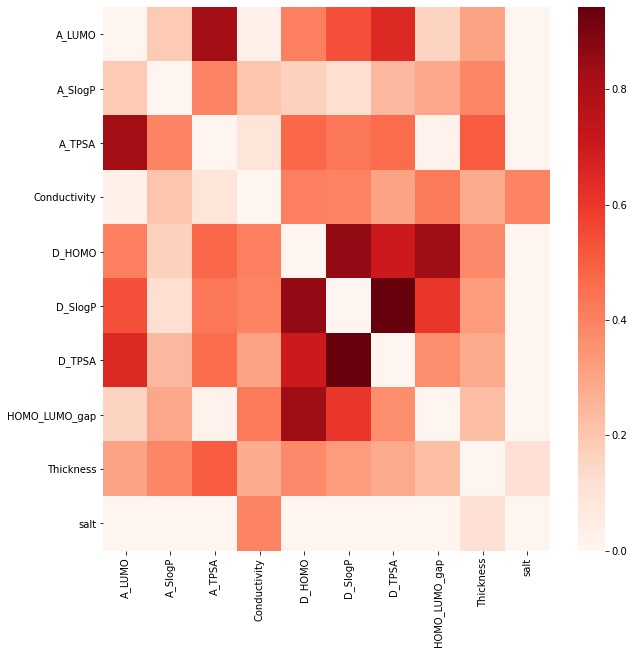

In [4]:
#show heatmap
heatmap(normal_coeff_list)

# make dependency graphs from the heatmap
    - the width of arrows corresponds to the absolute values of coefficients
    - less important relationships were cut off (can be tuned by coeff_cutoff)
    - the widths of arrows in both directions are always the same, due to the inherent nature of correlation analysis

removed:  salt
removed:  A_SlogP


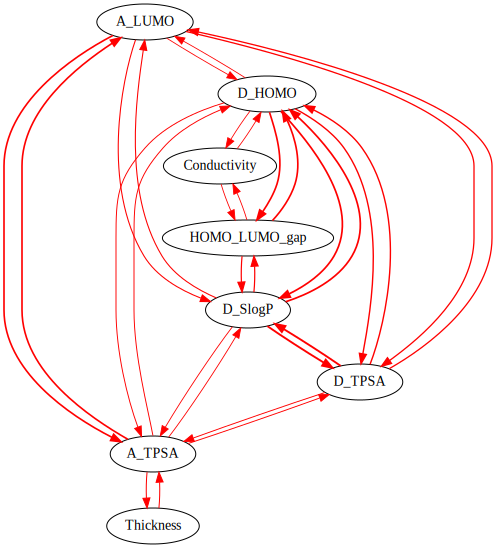

In [5]:
img,_=to_graph(normal_coeff_list,param_list,arrow_scale=2,coeff_cutoff=0.8)
display(SVG(img))

0.0


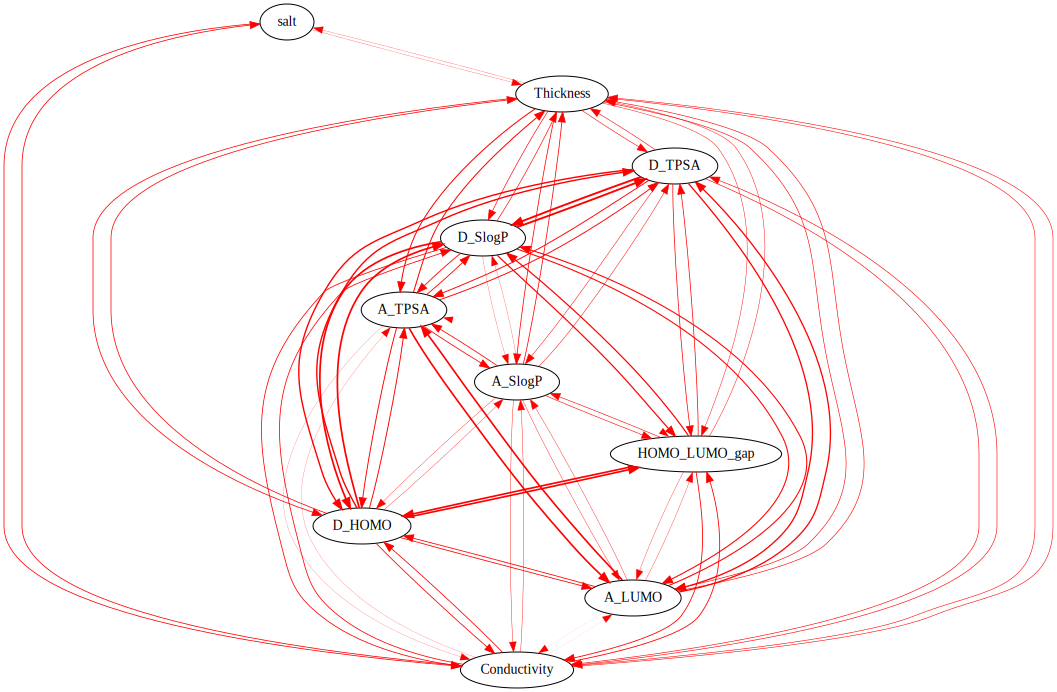

0.3333333333333333


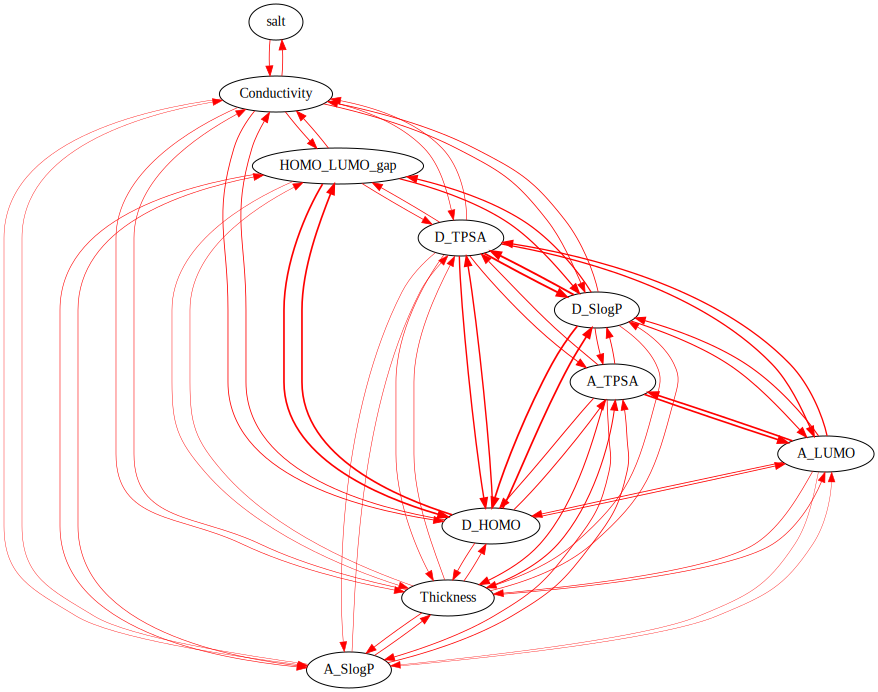

0.6666666666666666


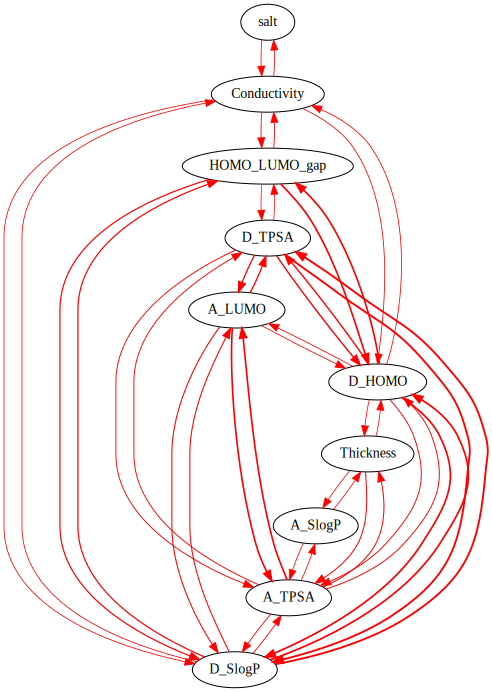

1.0
removed:  salt
removed:  Conductivity
removed:  A_SlogP


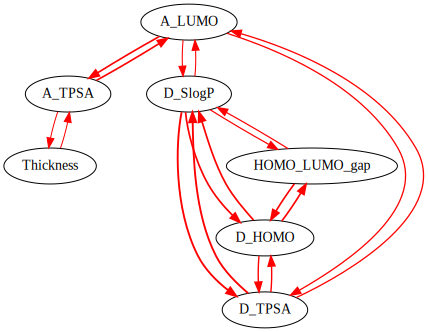

1.3333333333333333
removed:  salt
removed:  Thickness
removed:  Conductivity
removed:  A_SlogP


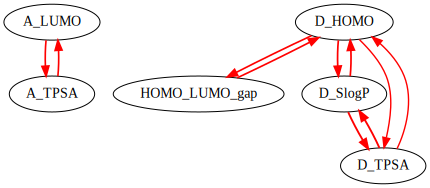

In [6]:
#we can change cut-off for the drawing graph edges
for i in range(5):
    cut=i/3
    print(cut)
    img,_=to_graph(normal_coeff_list,param_list,arrow_scale=2,coeff_cutoff=cut)
    display(SVG(img))

# our approach presented in the paper
- elastic net regression was repeated, by targetting each parameter
    - |coefficient of x_i|*(R2 value) for the prediction was used as Dji
    - elastic net can remove less-important dependencies
- bidirectional dependencies can be calculated

In [7]:
#calculate dependency list by elastic net
from sklearn.linear_model import ElasticNet
en=ENWrapper(ElasticNet(random_state=0,alpha=0.55))

all_coeff_list=[]
for j in df.columns:
    all_coeff_list.extend(get_coeff_list([j],df,en))

# heatmap
- it's more sparse than coeff analysis, thanks to the sparse modeling (= elastic net)
- dependency of parameters becomes slightly asymmetric

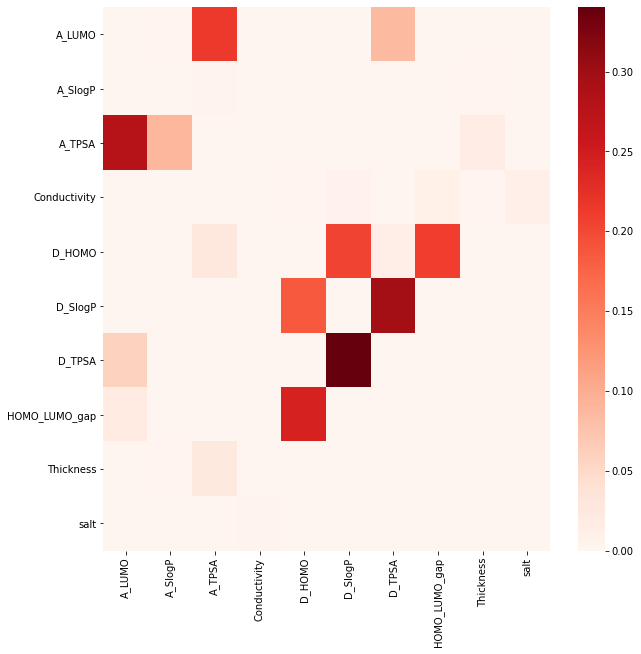

In [8]:
heatmap(all_coeff_list)

# check dependency graph


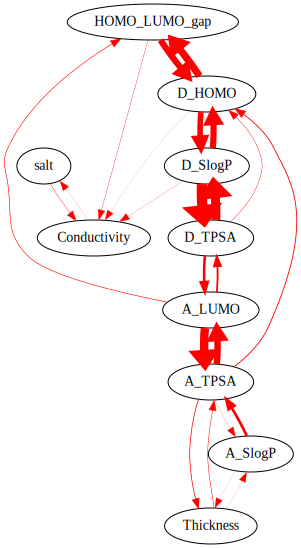

In [9]:
img,_=to_graph(all_coeff_list,param_list,coeff_cutoff=0.1)
display(SVG(img))

# We can check original R2 values for each parameter, if necessary

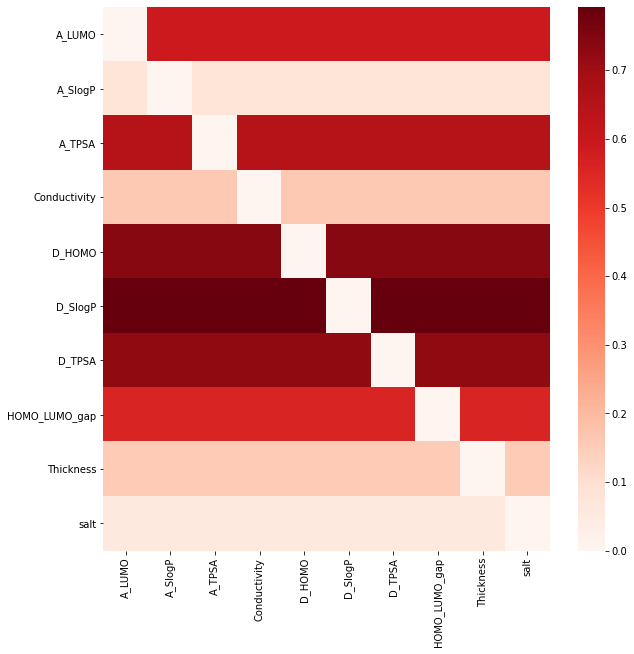

In [10]:
r2_coeff_list=[]
for j in df.columns:
    r2_coeff_list.extend(get_coeff_list([j],df,en,R2_mode=True))
    
heatmap(r2_coeff_list)

# Regresion can also be done via random forest regressor, if necessary

/home/kh/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/media/kh/python/20200613ctcomp/codes_rfr/AnalyzeUtil.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(x,y)
/media/kh/python/20200613ctcomp/codes_rfr/AnalyzeUtil.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(x,y)
/media/kh/python/20200613ctcomp/codes_rfr/AnalyzeUtil.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(x,y)
/media/kh/python/20200613ctcomp/codes

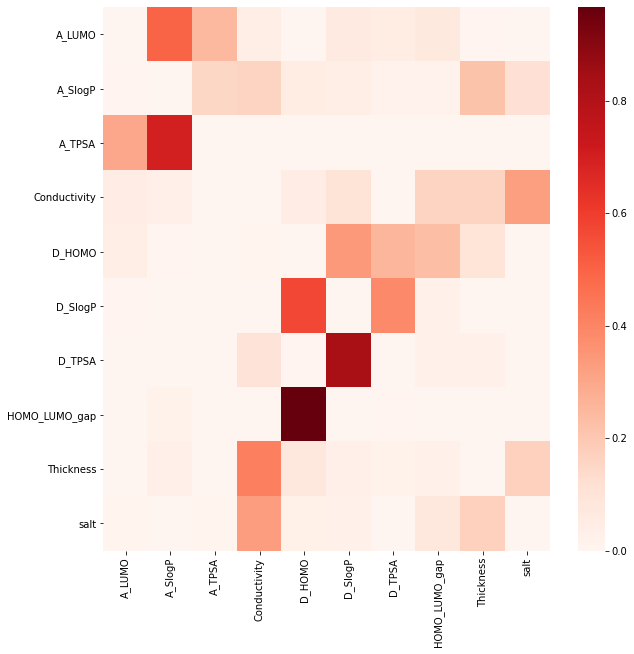

In [11]:
from sklearn.ensemble import RandomForestRegressor
rfr=RFRWrapper(RandomForestRegressor())
all_coeff_list=[]
for j in df.columns:
    all_coeff_list.extend(get_coeff_list([j],df,rfr))
    
heatmap(all_coeff_list)

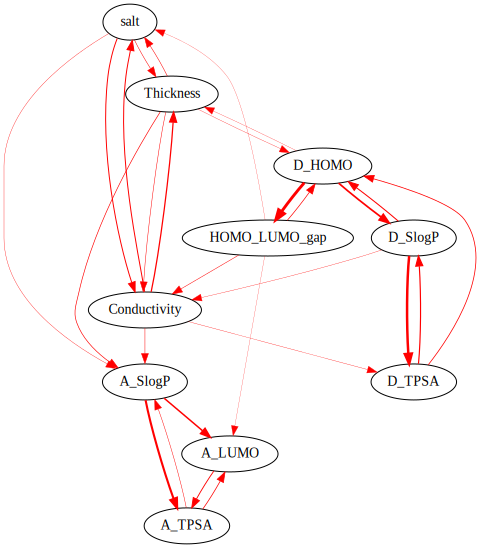

In [12]:
img,_=to_graph(all_coeff_list,param_list,coeff_cutoff=0.2,arrow_scale=3)
display(SVG(img))

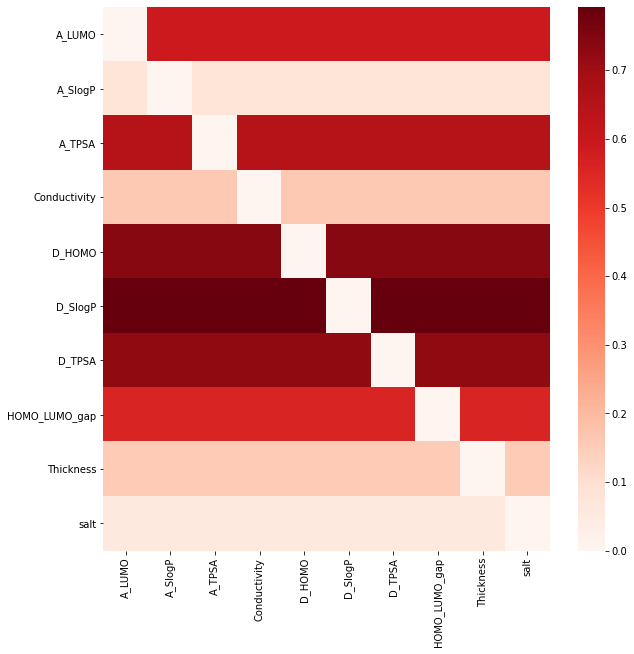

In [13]:
r2_coeff_list=[]
for j in df.columns:
    r2_coeff_list.extend(get_coeff_list([j],df,en,R2_mode=True))
    
heatmap(r2_coeff_list)